In [1]:
import numpy as np
import pandas as pd
import random
from random import randint
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

random.seed()

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Force_2020/train.csv')

In [3]:
data.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15-09-2013,494.528,437641.9688,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15-09-2013,494.680,437641.9688,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15-09-2013,494.832,437641.9688,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15-09-2013,494.984,437641.9688,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15-09-2013,495.136,437641.9688,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,NaN,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


In [4]:
data.shape

(1048575, 29)

The data contains the following columns

- WELL: well name
- DEPTH_MD: measured depth
- X_LOC: UTM X coordinate
- Y_LOC: UTM Y coordinate
- Z_LOC: DEPTH
- GROUP: NPD lithostratigraphy group
- FORMATION: NPD lithostratgraphy formation
- The data contains the well log curves. For example the following:

- BS: Bit Size
- CALI: Caliper
- RDEP: Deep Resistivity
- RHOB: Bulk Density
- GR: Raw gamma data
- SGR: Spectral Gamma Ray
- RMED: Medium Resistivity
- ROP: Rate of Penetration
- NPHI: Neutron Porosity
- PEF: Photoelectric Absorption Factor
- RSHA: Shallow Resistivity
- DTS: Sonic (Sheer Slowness)
- DTC: Sonic (Compressional Slowness)


 as well as the interpretation

- FORCE_2020_LITHOFACIES_LITHOLOGY: lithology class label
- FORCE_2020_LITHOFACIES_CONFIDENCE: confidence in lithology interpretation  (1: high, 2: medium, 3: low)

In [5]:
wells = data['WELL'].unique()
wells

array(['15-09-2013', '15-09-2015', '15-09-2017', '16-01-2002', '16/1-6 A',
       '16-10-2001', '16-10-2002', '16-10-2003', '16-10-2005',
       '16/11-1 ST3', '16/2-11 A', '16-02-2016', '16-02-2006',
       '16-04-2001', '16-05-2003', '16-07-2004', '16-07-2005',
       '16-08-2001', '17-11-2001', '25-11-2015', '25/11-19 S',
       '25-11-2005', '25/2-13 T4', '25-02-2014', '25-02-2007',
       '25-03-2001', '25-04-2005', '25-05-2001', '25-05-2004',
       '25-06-2001', '25-06-2002', '25-06-2003', '25-07-2002', '25/8-5 S',
       '25-08-2007', '25-09-2001', '26-04-2001', '29-06-2001',
       '30-03-2003', '30/3-5 S', '30-06-2005', '31/2-1', '31/2-19 S',
       '31/2-7', '31/2-8', '31/2-9', '31-03-2001', '31-03-2002',
       '31-03-2003', '31-03-2004', '31/4-10', '31/4-5', '31/5-4 S',
       '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S', '33/9-1',
       '33/9-17', '34/10-19', '34/10-21', '34/10-33', '34/10-35',
       '34/11-1', '34/11-2 S', '34/12-1', '34/2-4', '34/3-1 A',
       

In [6]:
data['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()

array([65000, 30000, 65030, 70000, 99000, 80000, 86000, 74000, 70032,
       90000, 88000, 93000])

Lithology column is not equally distributed

In [7]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

Text(0, 0.5, 'Lithology presence (\\%)')

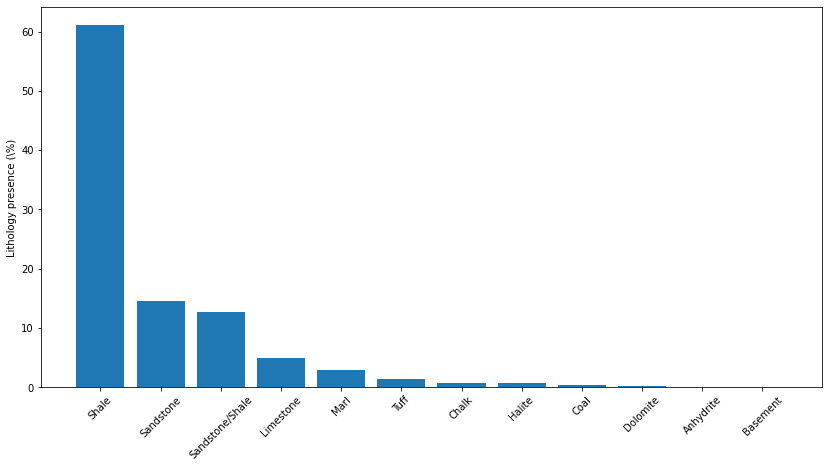

In [8]:
counts = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
names = []
percentage = []
N = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]
for item in counts.iteritems():
    names.append(lithology_keys[item[0]])
    percentage.append(float(item[1])/N*100)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (\%)')

# Checking missing values

In [9]:
data.isna().sum().sort_values(ascending = False)

SGR                                  985677
RMIC                                 913036
DTS                                  912421
ROPA                                 902089
DCAL                                 778296
MUDWEIGHT                            748117
RXO                                  736465
ROP                                  578569
BS                                   471132
RSHA                                 460853
PEF                                  459442
NPHI                                 378574
SP                                   234986
DRHO                                 166200
RHOB                                 146405
FORMATION                            123260
CALI                                  81504
DTC                                   53992
RMED                                  38174
RDEP                                  10770
Y_LOC                                 10561
X_LOC                                 10561
Z_LOC                           

# Plotting coorelation heatmap

After dropping the columns which has high missing values

In [10]:
X1 = data
X1 = X1.drop('WELL', axis = 1)
X1 = X1.drop('GROUP',axis = 1)
X1 = X1.drop('FORMATION',axis = 1)
X1 = X1.drop('RMIC', axis =1)
X1 = X1.drop('DTS', axis =1)
X1 = X1.drop('ROPA', axis =1)
X1 = X1.drop('RXO', axis =1)
X1 = X1.drop('MUDWEIGHT', axis =1)
X1 = X1.drop('DCAL', axis =1)

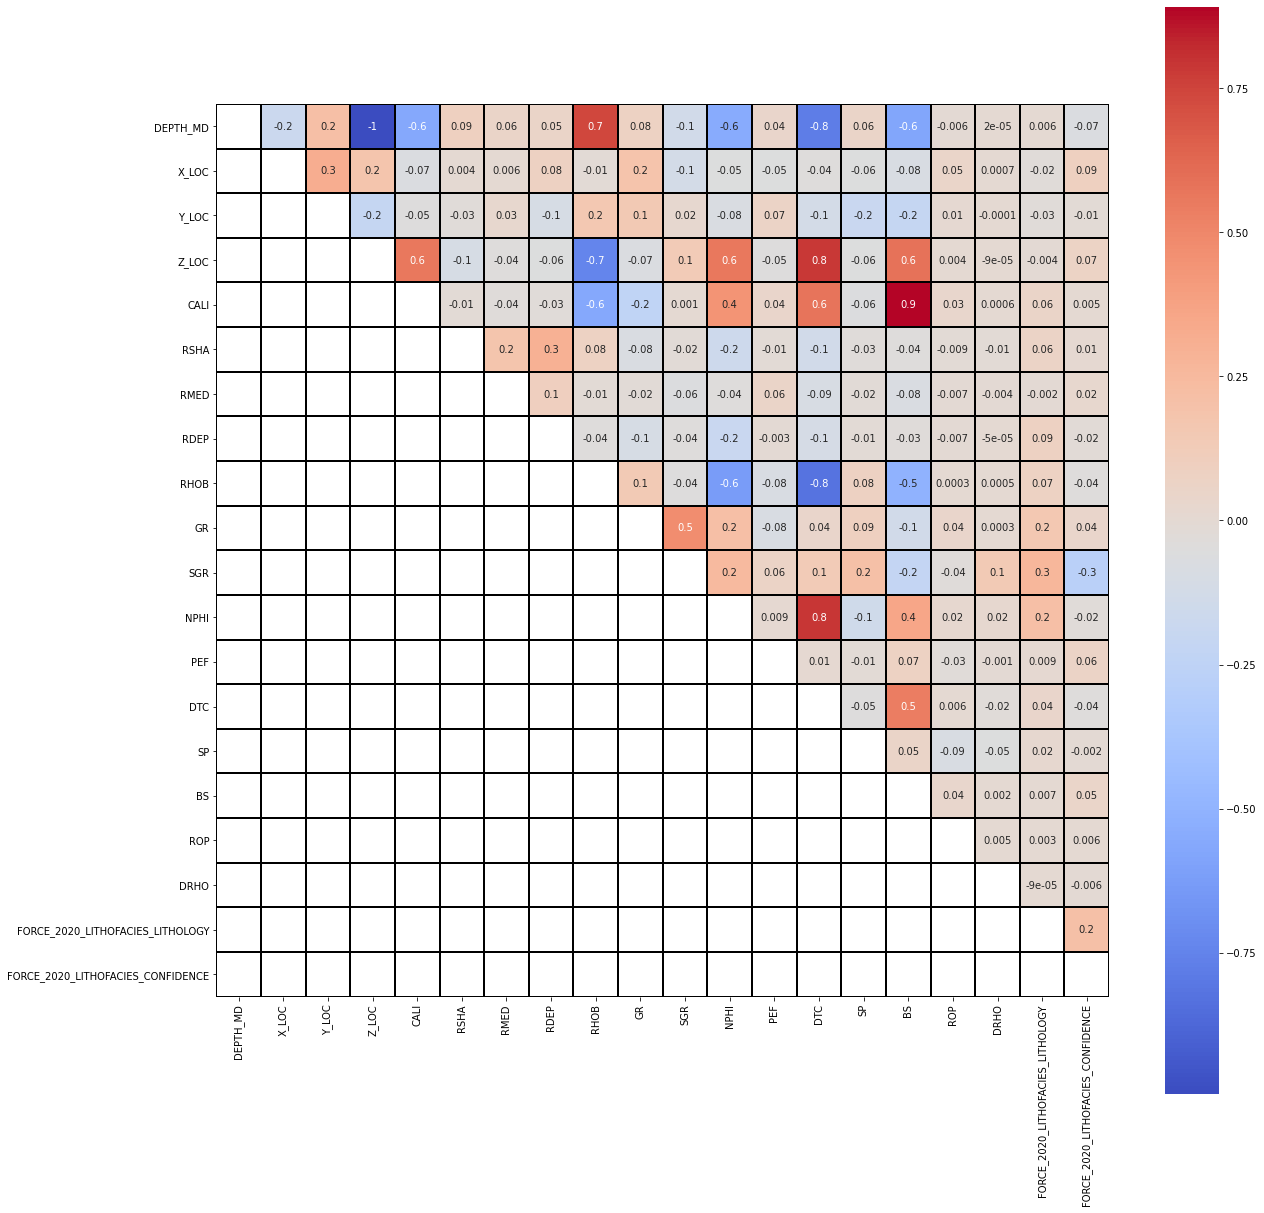

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
matrix = np.tril(X1.corr())
sns.heatmap(X1.corr(), annot = True,  linewidths=1, ax=ax, fmt='.1g', cmap= 'coolwarm',linecolor='black',square=True, mask=matrix)

# Preparing the data for training 
- converting lithology labels to numbers before training
- removing columns with high missing values
- removing highly coorelated features
- filling the missing values with 0
- shuffling the dataset to prevent overfitting
- normalizing the dataset
- reshaping the data as an input for for 1-D CNN



In [12]:
X1 = data
Y1 = data['FORCE_2020_LITHOFACIES_LITHOLOGY']
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

Y1 = Y1.map(lithology_numbers)
Y1 = pd.DataFrame(Y1)

In [13]:
X1 = X1.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis = 1)
X1 = X1.drop('FORCE_2020_LITHOFACIES_CONFIDENCE', axis = 1)
X1 = X1.drop('WELL', axis = 1)
X1 = X1.drop('GROUP',axis = 1)
X1 = X1.drop('FORMATION',axis = 1)
X1 = X1.drop('RMIC', axis =1)
X1 = X1.drop('DTS', axis =1)
X1 = X1.drop('ROPA', axis =1)
X1 = X1.drop('RXO', axis =1)
X1 = X1.drop('MUDWEIGHT', axis =1)
X1 = X1.drop('DCAL', axis =1)

###
X1 = X1.drop('BS', axis =1)
X1 = X1.drop('Z_LOC', axis =1)




In [14]:
X1.fillna(0, inplace=True)

In [15]:
Y1,X1 = shuffle(Y1,X1)
X1.head()

,DEPTH_MD,X_LOC,Y_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,ROP,DRHO
110677,2681.713201,0.0000,0.0,12.341233,0.00000,0.000000,0.000000,0.000000,8.383195,0.0,0.000000,0.000000,68.418266,0.000000,1.331703,0.000000
120125,1898.739200,475533.5625,6518960.5,13.366172,0.00000,1.241556,1.291423,2.300837,15.662930,0.0,0.287044,6.131105,87.138123,0.000000,9.933854,0.006976
510726,3015.038000,497358.5000,6737331.0,8.406200,1.37845,1.462368,1.388227,2.282371,16.628637,0.0,0.215300,0.000000,87.087677,15.200000,0.000000,0.000894
619544,1422.304901,536846.0625,6748636.5,0.000000,0.00000,0.950544,0.949667,2.189772,81.201279,0.0,0.447493,0.000000,136.557358,180.966431,0.000000,0.041917
1002542,1229.714000,520560.5000,6777354.0,0.000000,0.00000,1.147820,0.957601,0.000000,199.903198,0.0,0.000000,0.000000,0.000000,0.000000,34.281590,0.000000


In [16]:
X1.shape

(1048575, 16)

In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [18]:
X1 = sc.fit_transform(X1)
X1.shape, Y1.shape

((1048575, 16), (1048575, 1))

In [19]:
X1[0]

array([ 5.44429531e-01, -8.24885914e+00, -9.74723748e+00,  1.61946919e-02,
       -7.97332618e-02, -8.37610251e-02, -9.15910224e-02, -2.37744827e+00,
       -1.78109207e+00, -2.14310713e-01, -1.11512602e+00, -3.92448907e-01,
       -1.04628317e+00, -6.59020810e-01, -6.13632421e-02, -3.10700311e-04])

In [20]:
# reshaping the data
X1 = np.reshape(X1,( X1.shape[0], X1.shape[1], 1))


In [21]:
X1.shape, Y1.shape

((1048575, 16, 1), (1048575, 1))

In [22]:
#Importing convolutional layers

from tensorflow.keras.layers import Convolution1D
from tensorflow.keras.layers import MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, SpatialDropout1D
 
from tensorflow.keras.metrics import categorical_crossentropy

In [23]:
classifier = Sequential()

#Input shape must be explicitly defined, DO NOT USE (None,shape)!!!
#1.Multiple convolution and max pooling
classifier.add(Convolution1D(filters=64, kernel_size=3, activation="relu", input_shape=(16,1)))
classifier.add(BatchNormalization())
classifier.add(Convolution1D(filters=64, kernel_size=3, activation='relu'))
classifier.add(BatchNormalization( ))

classifier.add(MaxPooling1D(pool_size=5, strides=1))
classifier.add(BatchNormalization( ))


classifier.add(Convolution1D(filters=128, kernel_size=3, activation='relu'))
classifier.add(BatchNormalization( ))
classifier.add(Convolution1D(filters=128, kernel_size=3, activation='relu'))
classifier.add(BatchNormalization( ))

classifier.add(MaxPooling1D(pool_size=4, strides=1))
classifier.add(BatchNormalization( ))

classifier.add(Flatten())

classifier.add(Dropout(0.5))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.25))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(16, activation='relu'))
classifier.add(Dense(12, activation='softmax'))


# #Configure the learning process
classifier.compile(Adam(learning_rate = 0.01), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# #Train!
classifier.fit(X1, Y1, batch_size=1024, epochs=20, shuffle = True, validation_split=0.05)

Epoch 1/20
973/973 [==============================] - 19s 11ms/step - loss: 0.8281 - accuracy: 0.7381 - val_loss: 0.5347 - val_accuracy: 0.8297
Epoch 2/20
973/973 [==============================] - 10s 10ms/step - loss: 0.5291 - accuracy: 0.8311 - val_loss: 0.4703 - val_accuracy: 0.8432
Epoch 3/20
973/973 [==============================] - 10s 10ms/step - loss: 0.4796 - accuracy: 0.8463 - val_loss: 0.4325 - val_accuracy: 0.8561
Epoch 4/20
973/973 [==============================] - 10s 10ms/step - loss: 0.4594 - accuracy: 0.8519 - val_loss: 0.4313 - val_accuracy: 0.8597
Epoch 5/20
973/973 [==============================] - 10s 10ms/step - loss: 0.4431 - accuracy: 0.8565 - val_loss: 0.4054 - val_accuracy: 0.8673
Epoch 6/20
973/973 [==============================] - 10s 10ms/step - loss: 0.4326 - accuracy: 0.8605 - val_loss: 0.4031 - val_accuracy: 0.8647
Epoch 7/20
973/973 [==============================] - 10s 10ms/step - loss: 0.4211 - accuracy: 0.8639 - val_loss: 0.4270 - val_accuracy:

In [25]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 64)            256       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 64)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 128)            2